# Model Selection

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn import svm
from sklearn import preprocessing
import seaborn as sns


In [15]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
#### Read function to import data from the SQL to a pandas dataframe.
def readSQL(query):
    import pandas as pd
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    df = pd.read_sql_query(query, db)
    db.close()
    return(df)

#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
def writeSQL(df,tablename,overwrite=False, append=False):
    import pandas as pd
    import sqlite3 as sql
    db = sql.connect(DB_FILE)
    if (overwrite):
        action = "replace"
    elif (append):
        action = "append"
    else: 
        action = "fail"
    df.to_sql(tablename, db, if_exists=action)
    db.close()
def listTables():
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    cur = db.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
    res = cur.fetchall()
    cur.close()
    db.close()
    return(res)

In [16]:
import os
cwd = os.getcwd()
DB_FILE = "%s\Data\loans.db" % cwd

In [17]:
X_Train = readSQL('''SELECT * FROM X_train_scaled''')

In [18]:
Y_Train = readSQL('''SELECT * FROM Y_train''')

In [19]:
X_Train = X_Train.drop(["index"],axis=1)

In [20]:
Y_Train = Y_Train.drop(["index"],axis=1)

In [21]:
X_Dev = readSQL('''SELECT * FROM X_dev_scaled''')

In [22]:
X_Dev = X_Dev.drop(["index"],axis=1)

In [23]:
Y_Dev = readSQL('''SELECT * FROM Y_dev''')

In [24]:
Y_Dev = Y_Dev.drop(["index"],axis=1)

In [25]:
Y_Train = Y_Train.values.ravel()
Y_Dev = Y_Dev.values.ravel()

In [26]:
X_Train.head()

,initial_list_status,loan_amnt,funded_amnt,funded_amnt_inv,term,annual_inc,dti,delinq_2yrs,acc_now_delinq,inq_last_6mths,...,cat_delinq_2yrs_one,cat_delinq_2yrs_zero,cat_inq_last_6mths_more_than_2,cat_inq_last_6mths_one,cat_inq_last_6mths_zero,inc_grp_high_inc,inc_grp_low_inc,inc_grp_middle_inc,inc_grp_veryhigh_inc,credit_hist_grp_4_13_yrs
0,1,-0.431514,-0.427560,-1.374325,0,-0.822350,0.305064,-0.336436,-0.050085,0.097476,...,0,1,0,1,0,0,0,0,0,1
1,1,-0.998000,-0.995666,-1.595755,0,-0.691752,-0.058192,-0.336436,-0.050085,-0.766134,...,0,1,0,0,1,0,0,0,0,1
2,1,-1.478282,-1.477321,-1.570162,0,-1.307428,-0.296939,-0.336436,-0.050085,2.688304,...,0,1,1,0,0,0,0,0,0,1
3,1,-1.071890,-1.069767,-1.451210,0,-0.271973,-0.462522,-0.336436,-0.050085,1.824694,...,0,1,1,0,0,0,1,0,0,1
4,1,-1.071890,-1.069767,-1.441984,0,-1.088210,0.211362,1.014637,-0.050085,-0.766134,...,1,0,0,0,1,0,0,0,0,1


## LogisticRegression

In [27]:
# Initialize the predictive model object
mod_logistic = LogisticRegression(random_state=1207,solver ="saga", max_iter=10000,C=1)
# Train the model using the training sets
mod_logistic.fit(X_Train, Y_Train)
# Make predictions using the testing set
logistic_pred = mod_logistic.predict_proba(X_Dev)

In [29]:
import pickle
# save the model to disk
filename = 'logistic_base_model.sav'
pickle.dump(mod_logistic, open(filename, 'wb'))

## Naive Bayes

In [30]:
# Initialize the predictive model object
mod_bayes = GaussianNB()
# Train the model using the training sets
mod_bayes.fit(X_Train, Y_Train)
# Make predictions using the testing set
NB_pred = mod_bayes.predict_proba(X_Dev)

## Conditional Decision Tree

In [31]:
from sklearn import tree
# Initialize the predictive model object
mod_cart = tree.DecisionTreeClassifier(random_state=1207,max_depth=5)
# Train the model using the training sets
mod_cart.fit(X_Train, Y_Train)
# Make predictions using the testing set
CART_pred = mod_cart.predict_proba(X_Dev)

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the predictive model object
mod_rforest = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=1207)
# Train the model using the training sets
mod_rforest.fit(X_Train, Y_Train)
# Make predictions using the testing set
RF_pred = mod_rforest.predict_proba(X_Dev)

## AdaBoost

In [33]:
from sklearn.ensemble import AdaBoostClassifier
# Initialize the predictive model object
mod_ada = AdaBoostClassifier(random_state=1207)
# Train the model using the training sets
mod_ada.fit(X_Train, Y_Train)
# Make predictions using the testing set
AdaB_pred = mod_ada.predict_proba(X_Dev)

## XGBoost

In [34]:
# Transform data to a DMatrix object
dtrain = xgb.DMatrix(np.array(X_Train), label=Y_Train)
ddev = xgb.DMatrix(np.array(X_Dev), Y_Dev)


In [35]:
# Set the parameters for the xgboost
param = {'max_depth':5, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
#param['nthread'] = 10
param['eval_metric'] = 'auc'
# Train the model using the training sets
num_round = 10
mod_xgboost = xgb.train(param, dtrain, num_round)
# Make predictions using the testing set
predXGB = mod_xgboost.predict(ddev)
#predXGB_class = np.where(predXGB >= 0.5, 1, 0)

## Support Vector Machine

In [39]:
# Initialize the predictive model object
mod_svm = svm.SVC(kernel="linear", gamma="auto",probability=True, random_state=1207,max_iter=20000)
# Train the model using the training sets
mod_svm.fit(X_Train, Y_Train)
# Make predictions using the testing set
predSVM = mod_svm.predict_proba(X_Dev)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [41]:
# save the model to disk
filename = 'SVM_base_model.sav'
pickle.dump(mod_svm, open(filename, 'wb'))
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb

## Results

In [55]:
def showModelResult(X_Train, Y_Train,X_Dev,Y_Dev,model,pred):
    #print(model.score(X_Train, Y_Train))
    #print(model.score(X_Dev, Y_Dev))
   # print(pd.crosstab(Y_Dev, pred[:,1]))
    if(pred.shape==(25479, 2)):
        auc_score = metrics.roc_auc_score(Y_Dev, pred[:,1])
        fpr, tpr, thresholds = metrics.roc_curve(Y_Dev, pred[:,1])
    else:
        auc_score = metrics.roc_auc_score(Y_Dev, pred)
        fpr, tpr, thresholds = metrics.roc_curve(Y_Dev, pred)
    print(auc_score)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return (auc_score)

In [56]:
res =[]

0.6894901040048504


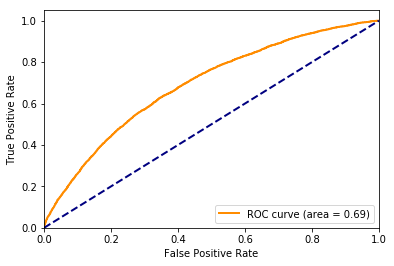

0.6243834511931625


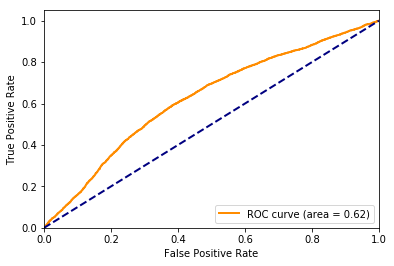

0.6501712001807786


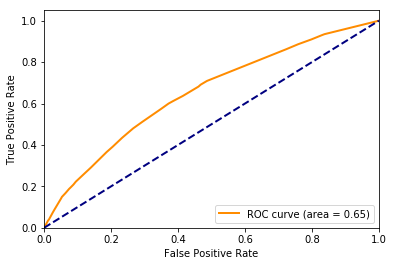

0.6734090170383185


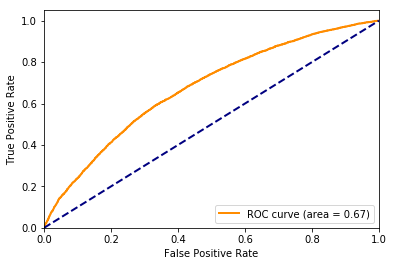

0.6829766597935745


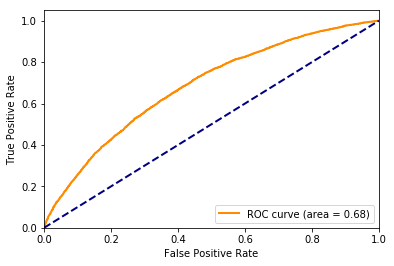

0.6832650199171383


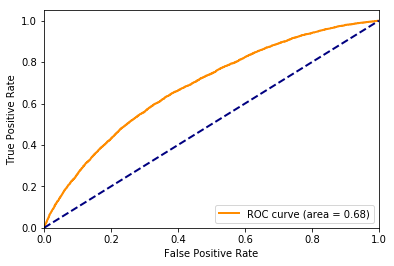

0.5217760123085764


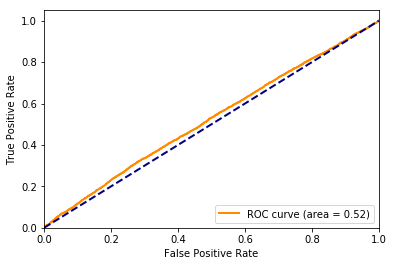

In [57]:
##LogisticRegression
acc = showModelResult(X_Train, Y_Train,X_Dev,Y_Dev,mod_logistic,logistic_pred)
res.append({'model':'Logistic regression','auc_score':acc})
##Naive Bayes
acc = showModelResult(X_Train, Y_Train,X_Dev,Y_Dev,mod_bayes,NB_pred)
res.append({'model':'Naive Bayes','auc_score':acc})
##CART
acc = showModelResult(X_Train, Y_Train,X_Dev,Y_Dev,mod_cart,CART_pred)
res.append({'model':'Conditional Tree','auc_score':acc})
##Random Forest
acc = showModelResult(X_Train, Y_Train,X_Dev,Y_Dev,mod_rforest,RF_pred)
res.append({'model':'Random Forest','auc_score':acc})
##AdaBoost
acc = showModelResult(X_Train, Y_Train,X_Dev,Y_Dev,mod_ada,AdaB_pred)
res.append({'model':'AdaBoost','auc_score':acc})
##XGBoost
acc = showModelResult(X_Train, Y_Train,X_Dev,Y_Dev,mod_xgboost,predXGB)
res.append({'model':'XGBoost','auc_score':acc})
#SVM
acc = showModelResult(X_Train, Y_Train,X_Dev,Y_Dev,mod_svm,predSVM)
res.append({'model':'SVM','auc_score':acc})

In [58]:

res

[{'model': 'Logistic regression', 'auc_score': 0.6894901040048504},
 {'model': 'Naive Bayes', 'auc_score': 0.6243834511931625},
 {'model': 'Conditional Tree', 'auc_score': 0.6501712001807786},
 {'model': 'Random Forest', 'auc_score': 0.6734090170383185},
 {'model': 'AdaBoost', 'auc_score': 0.6829766597935745},
 {'model': 'XGBoost', 'auc_score': 0.6832650199171383},
 {'model': 'SVM', 'auc_score': 0.5217760123085764}]

In [59]:
pd.DataFrame(res).sort_values(ascending=False,by=['auc_score'])

,auc_score,model
0,0.689490,Logistic regression
5,0.683265,XGBoost
4,0.682977,AdaBoost
3,0.673409,Random Forest
2,0.650171,Conditional Tree
1,0.624383,Naive Bayes
6,0.521776,SVM


### Ensembling check

In this section we checked the possibility to perform ensembling on the best performing algorithms. 

In [62]:
preds=pd.DataFrame({"Logistic regression":logistic_pred[:,1] ,"XGBoost":predXGB , "AdaBoost":AdaB_pred[:,1] , "Random Forest":RF_pred[:,1] , "Naive Bayes":NB_pred[:,1] ,
                     "Conditional Tree": CART_pred[:,1] ,"SVM":predSVM[:,1]} )


In [63]:
preds.head()

,Logistic regression,XGBoost,AdaBoost,Random Forest,Naive Bayes,Conditional Tree,SVM
0,0.217356,0.076650,0.490352,0.144333,9.999997e-01,0.131631,0.194802
1,0.195577,0.212182,0.492994,0.203216,6.358951e-01,0.201252,0.164610
2,0.202834,0.115326,0.491739,0.159927,4.587251e-08,0.167718,0.176046
3,0.130773,0.087489,0.488536,0.144462,7.080145e-02,0.131631,0.168395
4,0.242022,0.433893,0.491597,0.202868,3.639435e-01,0.151388,0.240918


In [64]:
corr =preds.corr()
preds.corr()

,Logistic regression,XGBoost,AdaBoost,Random Forest,Naive Bayes,Conditional Tree,SVM
Logistic regression,1.000000,0.838907,0.914563,0.855292,0.628498,0.757881,0.124922
XGBoost,0.838907,1.000000,0.803117,0.774591,0.507505,0.739008,0.109132
AdaBoost,0.914563,0.803117,1.000000,0.861526,0.583840,0.745488,0.115550
Random Forest,0.855292,0.774591,0.861526,1.000000,0.501867,0.854541,0.076956
Naive Bayes,0.628498,0.507505,0.583840,0.501867,1.000000,0.381642,0.128235
Conditional Tree,0.757881,0.739008,0.745488,0.854541,0.381642,1.000000,0.041869
SVM,0.124922,0.109132,0.115550,0.076956,0.128235,0.041869,1.000000


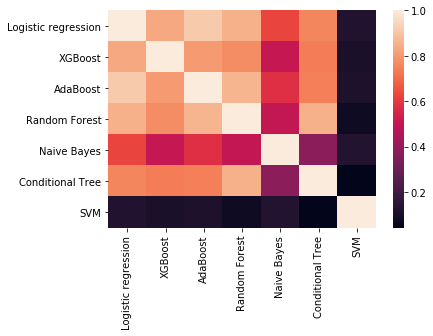

In [67]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

we can see that the correlation between XGboost and LR is 0.84 and between LR to Adaboost is 0.91.

Because of the high correlation between the high-ranking models and due to cost-benefit considerations and time constraints, we decided not to ensemble models and leave it to a future work.
<br>Instead, we moved on to preform a fine tuning to the highest rated models, XG and LR.